In [2]:
import csv
import datetime
from itertools import islice


datasetDir = 'FileLogGenerator\\'
GenTimeFormat = '%m/%d/%Y %H:%M:%S.%f'

f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)

GenUserActs = {}
count = 0
for row in fileData:
    if not row[4]:
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]
        fileName = row[9]
        fileLoc = row[10] #0: 로컬, 1: 서버, 2: 이메일
        fileRank = row[11]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['toWho'] = toWho
        userAct['fileName'] = fileName
        userAct['fileID'] = fileID
        userAct['fileLoc'] = fileLoc
        userAct['fileRank'] = fileRank

        if user in GenUserActs:
            GenUserActs[user].append(userAct)

        else:
            GenUserActs[user] = [userAct]
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['toWho'] = user
            plusUserAct['fileName'] = fileName
            plusUserAct['fileID'] = fileID
            plusUserAct['fileLoc'] = fileLoc
            plusUserAct['fileRank'] = fileRank
            if toWho in GenUserActs:
                GenUserActs[toWho].append(plusUserAct)

            else:
                GenUserActs[toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)
            
f.close()       
f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)
            
GenUserAttackActs = {}
ReciveFirstInActs = {}
count = 0
for row in fileData:
    if row[4]:
        AttackSet = row[4][0]
        if not AttackSet in GenUserAttackActs:
            GenUserAttackActs[AttackSet] = {}
            ReciveFirstInActs[AttackSet] = {}
            
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]
        fileName = row[9]
        fileLoc = row[10] #0: 로컬, 1: 서버, 2: 이메일
        fileRank = row[11]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['toWho'] = toWho
        userAct['fileName'] = fileName
        userAct['fileID'] = fileID
        userAct['fileLoc'] = fileLoc
        userAct['fileRank'] = fileRank

        if user in GenUserAttackActs[AttackSet]:
            GenUserAttackActs[AttackSet][user].append(userAct)

        else:
            if user in ReciveFirstInActs[AttackSet]:
                GenUserAttackActs[AttackSet][user] = ReciveFirstInActs[AttackSet][user]
                
            else:
                GenUserAttackActs[AttackSet][user] = []
            
            GenUserAttackActs[AttackSet][user].append(userAct)
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['toWho'] = user
            plusUserAct['fileName'] = fileName
            plusUserAct['fileID'] = fileID
            plusUserAct['fileLoc'] = fileLoc
            plusUserAct['fileRank'] = fileRank
            if toWho in GenUserAttackActs[AttackSet]:
                GenUserAttackActs[AttackSet][toWho].append(plusUserAct)

            else:
                if toWho in ReciveFirstInActs[AttackSet]:
                    ReciveFirstInActs[AttackSet][toWho].append(plusUserAct)
                    
                else:
                    ReciveFirstInActs[AttackSet][toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)
            
f.close()

['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'fileLocVal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']
['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'fileLocVal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']


In [3]:
# P00010 분석(로컬 - 자동 수집 - 압축)
def genActionsReadParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc):
                    fileReadCount += 1

            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileReadCount'] = fileReadCount
            userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadWindowInfo = {}
for user in GenUserActs:
    GenUserReadWindowInfo[user] = genActionsReadParse(GenUserActs[user], windowTime, 0)
    
GenUserAttackReadWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackReadWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackReadWindowInfo[attack][user] = genActionsReadParse(GenUserAttackActs[attack][user], windowTime, 0)
        

In [4]:
def genActionsReadTimeIntervalParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            fileReadInterval = windowTime

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc):
                    fileReadInterval = currentTime - datetime.datetime.strptime(cAcction['actTime'], GenTimeFormat)

            if fileReadInterval < windowTime:
                cWindowInfo = {}
                cWindowInfo['windowTimeStr'] = str(currentTime)
                cWindowInfo['windowTime'] = currentTime
                cWindowInfo['fileReadInterval'] = fileReadInterval
                userActionInfo.append(cWindowInfo)
                
            cWindow.append(action)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadWindowIntervalInfo = {}
for user in GenUserActs:
    GenUserReadWindowIntervalInfo[user] = genActionsReadTimeIntervalParse(GenUserActs[user], windowTime, 0)
    
GenUserAttackWindowIntervalInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackWindowIntervalInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackWindowIntervalInfo[attack][user] = genActionsReadTimeIntervalParse(GenUserAttackActs[attack][user], windowTime, 0)

In [5]:
def genActionsFileTrack(actions, fileID):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    fileTrackInfo = {}
    fileTrackInfo['readActCount'] = 0
    fileTrackInfo['writeActCount'] = 0
    startTrack = False
    for action in actions:
        if action['act'] == 'fileCreate':
            if action['fileID'] == fileID:
                startTrack = True
                currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)
                fileTrackInfo['fileCreatedTime'] = currentTime
                fileTrackInfo['fileCreatedTimeStr'] = str(currentTime)
                
        elif startTrack and action['act']  == 'fileRead':
            fileTrackInfo['readActCount'] += 1
            
        elif action['act'] == 'fileWrite' and action['fileID'] == fileID:
            fileTrackInfo['writeActCount'] += 1
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)
            fileTrackInfo['fileLastWriteTime'] = currentTime
            fileTrackInfo['fileLastWriteTimeStr'] = str(currentTime)
            
                
    return fileTrackInfo

    
genActionsFileTrackInfo = {}
for attack in GenUserAttackActs:
    genActionsFileTrackInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        genActionsFileTrackInfo[attack][user] = genActionsFileTrack(GenUserAttackActs[attack][user], 'F0000006785')
        
print(genActionsFileTrackInfo['A']['P00010'])
print(genActionsFileTrackInfo['A']['P00010']['fileLastWriteTime'] - genActionsFileTrackInfo['A']['P00010']['fileCreatedTime'])

{'readActCount': 183, 'writeActCount': 11, 'fileCreatedTime': datetime.datetime(2024, 9, 27, 9, 28, 30, 306412), 'fileCreatedTimeStr': '2024-09-27 09:28:30.306412', 'fileLastWriteTime': datetime.datetime(2024, 9, 27, 9, 28, 33, 454422), 'fileLastWriteTimeStr': '2024-09-27 09:28:33.454422'}
0:00:03.148010


In [6]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

                     windowTime fileReadCount            tag
617  2024-09-26 17:20:06.582437             1  P00010_attack
618  2024-09-26 17:20:06.917979             2  P00010_attack
619  2024-09-26 17:20:07.217556             3  P00010_attack
620  2024-09-26 17:20:07.335401             4  P00010_attack
621  2024-09-26 17:20:07.560158             5  P00010_attack
...                         ...           ...            ...
1310 2024-09-27 09:47:05.100301           272  P00010_attack
1311 2024-09-27 09:47:05.339718           273  P00010_attack
1312 2024-09-27 09:47:05.514145           274  P00010_attack
1313 2024-09-27 09:47:05.751378           275  P00010_attack
1314 2024-09-27 09:59:14.627597           275  P00010_attack

[698 rows x 3 columns]


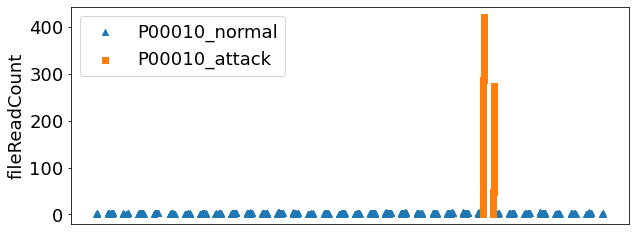

In [8]:
GenReadWindowDf = pd.DataFrame(columns=['windowTime', 'fileReadCount', 'tag'])
idx = 0
for key, vals in GenUserReadWindowInfo.items():
    if key == 'P00010':
        for val in vals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00010_normal']
            idx += 1


for key, Avals in GenUserAttackReadWindowInfo['A'].items():
    if key == 'P00010':
        for val in Avals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00010_attack']
            idx += 1
            
print(GenReadWindowDf[GenReadWindowDf['tag']=='P00010_attack'])
markers = ['^', 's']
tags = ['P00010_normal', 'P00010_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['fileReadCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadCount')
plt.show()

                     windowTime  fileReadInterval            tag
457  2024-09-26 17:20:06.917979          0.335542  P00010_attack
458  2024-09-26 17:20:07.217556          0.299577  P00010_attack
459  2024-09-26 17:20:07.335401          0.117845  P00010_attack
460  2024-09-26 17:20:07.560158          0.224757  P00010_attack
461  2024-09-26 17:20:07.739776          0.179618  P00010_attack
...                         ...               ...            ...
1148 2024-09-27 09:47:05.100301          0.103661  P00010_attack
1149 2024-09-27 09:47:05.339718          0.239417  P00010_attack
1150 2024-09-27 09:47:05.514145          0.174427  P00010_attack
1151 2024-09-27 09:47:05.751378          0.237233  P00010_attack
1152 2024-09-27 09:59:14.627597        728.876219  P00010_attack

[696 rows x 3 columns]


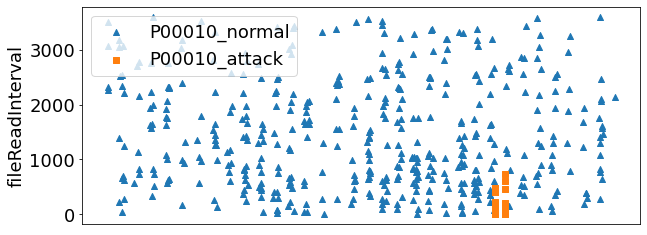


less then 3 sec


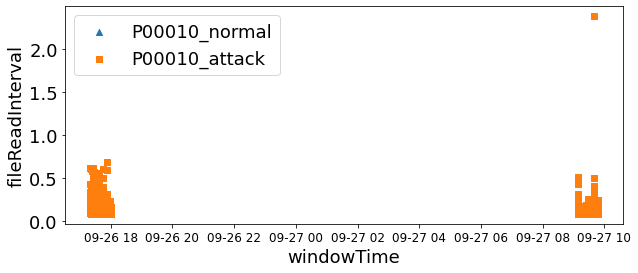

In [11]:
GenReadWindowIntervalDf = pd.DataFrame(columns=['windowTime', 'fileReadInterval', 'tag'])
idx = 0
for key, vals in GenUserReadWindowIntervalInfo.items():
    if key == 'P00010':
        for val in vals:
            GenReadWindowIntervalDf.loc[idx] = [val['windowTime'], val['fileReadInterval']/datetime.timedelta(seconds=1), 'P00010_normal']
            idx += 1


for key, Avals in GenUserAttackWindowIntervalInfo['A'].items():
    if key == 'P00010':
        for val in Avals:
            GenReadWindowIntervalDf.loc[idx] = [val['windowTime'], val['fileReadInterval']/datetime.timedelta(seconds=1), 'P00010_attack']
            idx += 1
            
print(GenReadWindowIntervalDf[GenReadWindowIntervalDf['tag']=='P00010_attack'])
markers = ['^', 's']
tags = ['P00010_normal', 'P00010_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowIntervalDf[GenReadWindowIntervalDf['tag']==tags[i]]['windowTime']
    y_axis = GenReadWindowIntervalDf[GenReadWindowIntervalDf['tag']==tags[i]]['fileReadInterval']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadInterval')
plt.show()

print()
print('less then 3 sec')
plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.rc('xtick', labelsize=12) 
plt.gca().axes.xaxis.set_visible(True)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowIntervalDf[(GenReadWindowIntervalDf['tag']==tags[i]) & (GenReadWindowIntervalDf['fileReadInterval'] < 3)]['windowTime']
    y_axis = GenReadWindowIntervalDf[(GenReadWindowIntervalDf['tag']==tags[i]) & (GenReadWindowIntervalDf['fileReadInterval'] < 3)]['fileReadInterval']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadInterval')
plt.show()

In [12]:
def genActionsCopyParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break

        fileCopyCount = 0
        windowFlag = False
        if action['act'] == 'fileCreate':
            revCWindow = list(reversed(cWindow))
            
            for cAcction in revCWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc) and cAcction['fileName'] in action['fileName']:
                    windowFlag = True
                    fileCopyCount += 1
                    break
                    
        if windowFlag:
            for idx, restAction in enumerate(revCWindow):
                if restAction['act'] == 'fileCreate':
                    for restCAction in revCWindow[idx+1:]:
                        if restCAction['act'] == 'fileRead' and restCAction['fileLoc'] == str(fileLoc) and restCAction['fileName'] in restAction['fileName']:
                            fileCopyCount += 1
                            break
            
            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileCopyCount'] = fileCopyCount
            userActionInfo.append(cWindowInfo)

        cWindow.append(action)

        preWindow = cWindow
        
    return userActionInfo

GenUserCopyWindowInfo = {}
for user in GenUserActs:
    GenUserCopyWindowInfo[user] = genActionsCopyParse(GenUserActs[user], windowTime, 0)
    
GenUserAttackCopyWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackCopyWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackCopyWindowInfo[attack][user] = genActionsCopyParse(GenUserAttackActs[attack][user], windowTime, 0)
        
print(GenUserCopyWindowInfo['P00010'])

[]


Empty DataFrame
Columns: [windowTime, fileCopyCount, tag]
Index: []


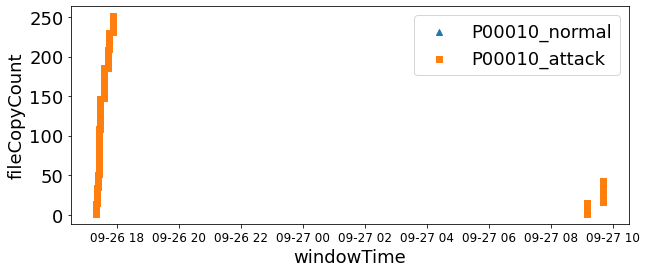

In [14]:
GenCopyWindowDf = pd.DataFrame(columns=['windowTime', 'fileCopyCount', 'tag'])
idx = 0
for key, vals in GenUserCopyWindowInfo.items():
    if key == 'P00010':
        for val in vals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00010_normal']
            idx += 1


for key, Avals in GenUserAttackCopyWindowInfo['A'].items():
    if key == 'P00010':
        for val in Avals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00010_attack']
            idx += 1
            
print(GenCopyWindowDf[GenCopyWindowDf['tag']=='P00010_normal'])
markers = ['^', 's']
tags = ['P00010_normal', 'P00010_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.rc('xtick', labelsize=12) 
plt.gca().axes.xaxis.set_visible(True)

for i, marker in enumerate(markers):
    x_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['fileCopyCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileCopyCount')
plt.show()

In [15]:
# P00011 분석(서버 - 읽고 저장)
def genActionsReadParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc):
                    fileReadCount += 1

            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileReadCount'] = fileReadCount
            userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadWindowInfo = {}
for user in GenUserActs:
    GenUserReadWindowInfo[user] = genActionsReadParse(GenUserActs[user], windowTime, 1)
    
GenUserAttackReadWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackReadWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackReadWindowInfo[attack][user] = genActionsReadParse(GenUserAttackActs[attack][user], windowTime, 1)

In [16]:
def genActionsServerReadRankParse(actions, windowTime):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0
            fileRank1Count = 0
            fileRank2Count = 0
            fileRank3Count = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(1):
                    fileReadCount += 1
                    if cAcction['fileRank'] == str(1):
                        fileRank1Count += 1
                        
                    elif cAcction['fileRank'] == str(2):
                        fileRank2Count += 1
                        
                    elif cAcction['fileRank'] == str(3):
                        fileRank3Count += 1

            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileReadCount'] = fileReadCount
            cWindowInfo['fileRank1Count'] = fileRank1Count
            cWindowInfo['fileRank2Count'] = fileRank2Count
            cWindowInfo['fileRank3Count'] = fileRank3Count
            userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadRankWindowInfo = {}
for user in GenUserActs:
    GenUserReadRankWindowInfo[user] = genActionsServerReadRankParse(GenUserActs[user], windowTime)
    
GenUserAttackReadRankWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackReadRankWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackReadRankWindowInfo[attack][user] = genActionsServerReadRankParse(GenUserAttackActs[attack][user], windowTime)

In [17]:
def genActionsServerReadRankPortionParse(actions, windowTime):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0
            fileRank1Count = 0
            fileRank2Count = 0
            fileRank3Count = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(1):
                    fileReadCount += 1
                    if cAcction['fileRank'] == str(1):
                        fileRank1Count += 1
                        
                    elif cAcction['fileRank'] == str(2):
                        fileRank2Count += 1
                        
                    elif cAcction['fileRank'] == str(3):
                        fileRank3Count += 1
            
            totalRankCount = fileRank1Count + fileRank2Count + fileRank3Count
            if totalRankCount > 0:
                cWindowInfo = {}
                cWindowInfo['windowTimeStr'] = str(currentTime)
                cWindowInfo['windowTime'] = currentTime
                cWindowInfo['fileReadCount'] = fileReadCount
                cWindowInfo['fileRank1Count'] = fileRank1Count / totalRankCount
                cWindowInfo['fileRank2Count'] = fileRank2Count / totalRankCount
                cWindowInfo['fileRank3Count'] = fileRank3Count / totalRankCount
                userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadRankPortionWindowInfo = {}
for user in GenUserActs:
    GenUserReadRankPortionWindowInfo[user] = genActionsServerReadRankPortionParse(GenUserActs[user], windowTime)
    
GenUserAttackReadRankPortionWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackReadRankPortionWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackReadRankPortionWindowInfo[attack][user] = genActionsServerReadRankPortionParse(GenUserAttackActs[attack][user], windowTime)

In [18]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

                    windowTime fileReadCount            tag
494 2024-09-26 17:22:01.740448             1  P00011_attack
495 2024-09-26 17:27:14.626931             2  P00011_attack
496 2024-09-26 17:28:50.519914             3  P00011_attack
497 2024-09-26 17:29:29.623156             4  P00011_attack
498 2024-09-26 17:30:08.578528             5  P00011_attack
..                         ...           ...            ...
852 2024-09-30 14:23:34.037988             0  P00011_attack
853 2024-09-30 14:24:05.699200             0  P00011_attack
854 2024-09-30 14:25:43.518905             0  P00011_attack
855 2024-09-30 14:32:37.745636             0  P00011_attack
856 2024-09-30 14:39:47.543855             0  P00011_attack

[363 rows x 3 columns]


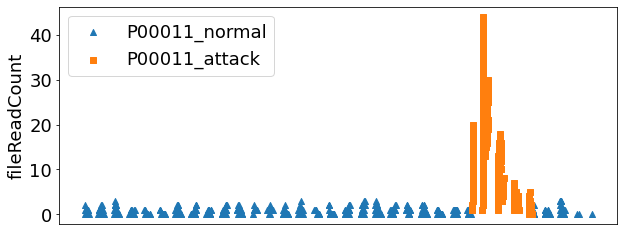

In [19]:
GenReadWindowDf = pd.DataFrame(columns=['windowTime', 'fileReadCount', 'tag'])
idx = 0
for key, vals in GenUserReadWindowInfo.items():
    if key == 'P00011':
        for val in vals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00011_normal']
            idx += 1


for key, Avals in GenUserAttackReadWindowInfo['A'].items():
    if key == 'P00011':
        for val in Avals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00011_attack']
            idx += 1
            
print(GenReadWindowDf[GenReadWindowDf['tag']=='P00011_attack'])
markers = ['^', 's']
tags = ['P00011_normal', 'P00011_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['fileReadCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadCount')
plt.show()

In [20]:
def genActionsCopyParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break

        fileCopyCount = 0
        windowFlag = False
        if action['act'] == 'fileCreate':
            revCWindow = list(reversed(cWindow))
            
            for cAcction in revCWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc) and cAcction['fileName'] in action['fileName']:
                    windowFlag = True
                    fileCopyCount += 1
                    break
                    
        if windowFlag:
            for idx, restAction in enumerate(revCWindow):
                if restAction['act'] == 'fileCreate':
                    for restCAction in revCWindow[idx+1:]:
                        if restCAction['act'] == 'fileRead' and restCAction['fileLoc'] == str(fileLoc) and restCAction['fileName'] in restAction['fileName']:
                            fileCopyCount += 1
                            break
            
            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileCopyCount'] = fileCopyCount
            userActionInfo.append(cWindowInfo)

        cWindow.append(action)

        preWindow = cWindow
        
    return userActionInfo

GenUserCopyWindowInfo = {}
for user in GenUserActs:
    GenUserCopyWindowInfo[user] = genActionsCopyParse(GenUserActs[user], windowTime, 1)
    
GenUserAttackCopyWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackCopyWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackCopyWindowInfo[attack][user] = genActionsCopyParse(GenUserAttackActs[attack][user], windowTime, 1)
        
print(GenUserCopyWindowInfo['P00011'])

[]


Empty DataFrame
Columns: [windowTime, fileCopyCount, tag]
Index: []


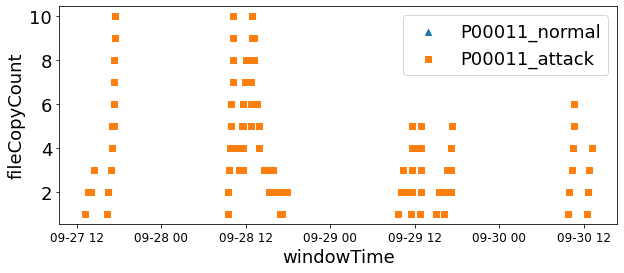

In [21]:
GenCopyWindowDf = pd.DataFrame(columns=['windowTime', 'fileCopyCount', 'tag'])
idx = 0
for key, vals in GenUserCopyWindowInfo.items():
    if key == 'P00011':
        for val in vals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00011_normal']
            idx += 1


for key, Avals in GenUserAttackCopyWindowInfo['A'].items():
    if key == 'P00011':
        for val in Avals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00011_attack']
            idx += 1
            
print(GenCopyWindowDf[GenCopyWindowDf['tag']=='P00011_normal'])
markers = ['^', 's']
tags = ['P00011_normal', 'P00011_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.rc('xtick', labelsize=12) 
plt.gca().axes.xaxis.set_visible(True)

for i, marker in enumerate(markers):
    x_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['fileCopyCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileCopyCount')
plt.show()

In [22]:
NormalWindowRank =[]
AttackWindowRank = []

NormalAttackWindowRank = None
NormalAttackWindowRankTag = []
firstSetFlag = True
for key, vals in GenUserReadRankWindowInfo.items():
    if key == 'P00011':
        for val in vals:
            if firstSetFlag:
                NormalAttackWindowRank = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
                firstSetFlag = False
                
            else:
                newArray = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
                NormalAttackWindowRank = np.append(NormalAttackWindowRank, newArray, axis=0)
                
            NormalWindowRank.append([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']])
            NormalAttackWindowRankTag.append('P00011_normal')
            
for key, Avals in GenUserAttackReadRankWindowInfo['A'].items():
    if key == 'P00011':
        for val in Avals:
            newArray = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
            NormalAttackWindowRank = np.append(NormalAttackWindowRank, newArray, axis=0)
            
            AttackWindowRank.append([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']])
            NormalAttackWindowRankTag.append('P00011_attack')

In [23]:
NormalWindowRankStatic = {}
NormalWindowRankStatic['means'] = np.mean(NormalWindowRank, axis=0)
NormalWindowRankStatic['vars'] = np.var(NormalWindowRank, axis=0)
NormalWindowRankStatic['covM'] = np.cov(NormalWindowRank, rowvar=False)

AttackWindowRankStatic = {}
AttackWindowRankStatic['means'] = np.mean(AttackWindowRank, axis=0)
AttackWindowRankStatic['vars'] = np.var(AttackWindowRank, axis=0)
AttackWindowRankStatic['covM'] = np.cov(AttackWindowRank, rowvar=False)

print('P00011_normal')
print(NormalWindowRankStatic)

print()

print('P00011_attack')
print(AttackWindowRankStatic)

P00011_normal
{'means': array([0.34412955, 0.2611336 , 0.04048583]), 'vars': array([0.31882181, 0.23747726, 0.03884673]), 'covM': array([[ 0.31946851,  0.00326022, -0.01396063],
       [ 0.00326022,  0.23795896, -0.00045167],
       [-0.01396063, -0.00045167,  0.03892552]])}

P00011_attack
{'means': array([1.49035813, 5.49311295, 9.13774105]), 'vars': array([ 2.5474277 , 12.19485615, 43.41904393]), 'covM': array([[ 2.55446479,  1.85697761,  1.15050302],
       [ 1.85697761, 12.2285436 , 16.90150374],
       [ 1.15050302, 16.90150374, 43.53898604]])}


In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(NormalAttackWindowRank)
NormalAttackWindowRankPCA = pca.transform(NormalAttackWindowRank)

pcaColumns = ['pcaComp1', 'pcaComp2']
NormalAttackWindowRankPCA_DF = pd.DataFrame(NormalAttackWindowRankPCA, columns = pcaColumns)

NormalAttackWindowRankPCA_DF['tag'] = NormalAttackWindowRankTag

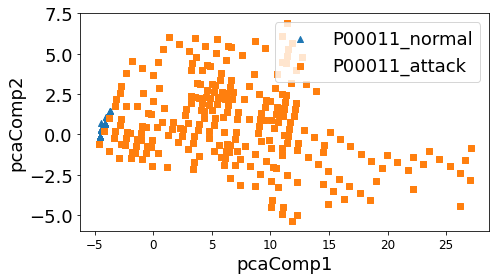

In [25]:
markers = ['^', 's']
tags = ['P00011_normal', 'P00011_attack']

plt.figure(figsize=(11*2/3, 6*2/3))

for i, marker in enumerate(markers):
    x_axis = NormalAttackWindowRankPCA_DF[NormalAttackWindowRankPCA_DF['tag']==tags[i]]['pcaComp1']
    y_axis = NormalAttackWindowRankPCA_DF[NormalAttackWindowRankPCA_DF['tag']==tags[i]]['pcaComp2']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('pcaComp1')
plt.ylabel('pcaComp2')
plt.show()

In [26]:
NormalWindowRank =[]
AttackWindowRank = []

NormalAttackWindowRank = None
NormalAttackWindowRankTag = []
firstSetFlag = True
for key, vals in GenUserReadRankPortionWindowInfo.items():
    if key == 'P00011':
        for val in vals:
            if firstSetFlag:
                NormalAttackWindowRank = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
                firstSetFlag = False
                
            else:
                newArray = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
                NormalAttackWindowRank = np.append(NormalAttackWindowRank, newArray, axis=0)
                
            NormalWindowRank.append([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']])
            NormalAttackWindowRankTag.append('P00011_normal')
            
for key, Avals in GenUserAttackReadRankPortionWindowInfo['A'].items():
    if key == 'P00011':
        for val in Avals:
            newArray = np.reshape([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']], (1,3))
            NormalAttackWindowRank = np.append(NormalAttackWindowRank, newArray, axis=0)
            
            AttackWindowRank.append([val['fileRank1Count'], val['fileRank2Count'], val['fileRank3Count']])
            NormalAttackWindowRankTag.append('P00011_attack')

In [27]:
NormalWindowRankStatic = {}
NormalWindowRankStatic['means'] = np.mean(NormalWindowRank, axis=0)
NormalWindowRankStatic['vars'] = np.var(NormalWindowRank, axis=0)
NormalWindowRankStatic['covM'] = np.cov(NormalWindowRank, rowvar=False)

AttackWindowRankStatic = {}
AttackWindowRankStatic['means'] = np.mean(AttackWindowRank, axis=0)
AttackWindowRankStatic['vars'] = np.var(AttackWindowRank, axis=0)
AttackWindowRankStatic['covM'] = np.cov(AttackWindowRank, rowvar=False)

print('P00011_normal')
print(NormalWindowRankStatic)

print()

print('P00011_attack')
print(AttackWindowRankStatic)

P00011_normal
{'means': array([0.53005464, 0.39822404, 0.07172131]), 'vars': array([0.21221147, 0.19763346, 0.06145441]), 'covM': array([[ 0.21308477, -0.17491211, -0.03817266],
       [-0.17491211,  0.19844676, -0.02353465],
       [-0.03817266, -0.02353465,  0.06170731]])}

P00011_attack
{'means': array([0.10273241, 0.3488287 , 0.54843889]), 'vars': array([0.01112665, 0.02724931, 0.03081921]), 'covM': array([[ 0.01115835, -0.00378914, -0.00736921],
       [-0.00378914,  0.02732695, -0.02353781],
       [-0.00736921, -0.02353781,  0.03090702]])}


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(NormalAttackWindowRank)
NormalAttackWindowRankPCA = pca.transform(NormalAttackWindowRank)

pcaColumns = ['pcaComp1', 'pcaComp2']
NormalAttackWindowRankPCA_DF = pd.DataFrame(NormalAttackWindowRankPCA, columns = pcaColumns)

NormalAttackWindowRankPCA_DF['tag'] = NormalAttackWindowRankTag

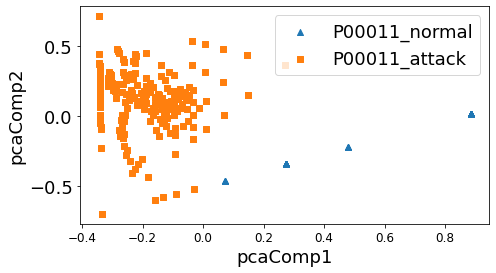

In [29]:
markers = ['^', 's']
tags = ['P00011_normal', 'P00011_attack']

plt.figure(figsize=(11*2/3, 6*2/3))
plt.rc('font', size=18)

for i, marker in enumerate(markers):
    x_axis = NormalAttackWindowRankPCA_DF[NormalAttackWindowRankPCA_DF['tag']==tags[i]]['pcaComp1']
    y_axis = NormalAttackWindowRankPCA_DF[NormalAttackWindowRankPCA_DF['tag']==tags[i]]['pcaComp2']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('pcaComp1')
plt.ylabel('pcaComp2')
plt.show()

In [30]:
# P00012 분석(이메일 - 읽고 저장)
def genActionsReadParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc):
                    fileReadCount += 1

            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileReadCount'] = fileReadCount
            userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserReadWindowInfo = {}
for user in GenUserActs:
    GenUserReadWindowInfo[user] = genActionsReadParse(GenUserActs[user], windowTime, 2)
    
GenUserAttackReadWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackReadWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackReadWindowInfo[attack][user] = genActionsReadParse(GenUserAttackActs[attack][user], windowTime, 2)

In [31]:
def genActionsEmailReadPortionParse(actions, windowTime):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        if action['act'] == 'fileReceive':
            preWindow.append(action)
            
        elif action['act'] == 'fileRead':
            cWindow = []
            currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

            for idx in range(len(preWindow)):
                if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                    cWindow = preWindow[idx:]
                    break

            cWindow.append(action)
            fileReadCount = 0
            fileReceiveCount = 0

            for cAcction in cWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(2):
                    fileReadCount += 1
                    
                elif cAcction['act'] == 'fileReceive':
                    fileReceiveCount += 1

            if fileReceiveCount > 0:
                cWindowInfo = {}
                cWindowInfo['windowTimeStr'] = str(currentTime)
                cWindowInfo['windowTime'] = currentTime
                cWindowInfo['fileReadCount'] = fileReadCount / fileReceiveCount
                userActionInfo.append(cWindowInfo)
                
            else:
                cWindowInfo = {}
                cWindowInfo['windowTimeStr'] = str(currentTime)
                cWindowInfo['windowTime'] = currentTime
                cWindowInfo['fileReadCount'] = fileReadCount / 1
                userActionInfo.append(cWindowInfo)

            preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserEmailReadPortionWindowInfo = {}
for user in GenUserActs:
    GenUserEmailReadPortionWindowInfo[user] = genActionsEmailReadPortionParse(GenUserActs[user], windowTime)
    
GenUserAttackEmailReadPortionWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackEmailReadPortionWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackEmailReadPortionWindowInfo[attack][user] = genActionsEmailReadPortionParse(GenUserAttackActs[attack][user], windowTime)

In [32]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

                    windowTime fileReadCount            tag
507 2024-09-26 17:22:13.922860             1  P00012_attack
508 2024-09-26 17:24:05.506372             2  P00012_attack
509 2024-09-26 17:27:56.812386             3  P00012_attack
510 2024-09-26 17:29:05.655336             4  P00012_attack
511 2024-09-26 17:34:47.246802             5  P00012_attack
..                         ...           ...            ...
786 2024-09-30 13:29:06.535364             1  P00012_attack
787 2024-09-30 13:40:37.660506             1  P00012_attack
788 2024-09-30 13:49:00.394348             0  P00012_attack
789 2024-09-30 13:55:28.557205             0  P00012_attack
790 2024-09-30 14:07:10.057372             0  P00012_attack

[284 rows x 3 columns]


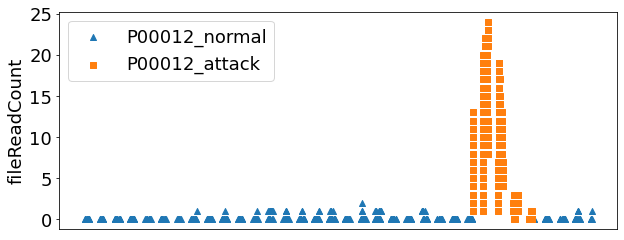

In [33]:
GenReadWindowDf = pd.DataFrame(columns=['windowTime', 'fileReadCount', 'tag'])
idx = 0
for key, vals in GenUserReadWindowInfo.items():
    if key == 'P00012':
        for val in vals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00012_normal']
            idx += 1


for key, Avals in GenUserAttackReadWindowInfo['A'].items():
    if key == 'P00012':
        for val in Avals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00012_attack']
            idx += 1
            
print(GenReadWindowDf[GenReadWindowDf['tag']=='P00012_attack'])
markers = ['^', 's']
tags = ['P00012_normal', 'P00012_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['fileReadCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadCount')
plt.show()

                    windowTime  fileReadCount            tag
507 2024-09-26 17:22:13.922860            1.0  P00012_attack
508 2024-09-26 17:24:05.506372            2.0  P00012_attack
509 2024-09-26 17:27:56.812386            3.0  P00012_attack
510 2024-09-26 17:29:05.655336            4.0  P00012_attack
511 2024-09-26 17:34:47.246802            5.0  P00012_attack
..                         ...            ...            ...
786 2024-09-30 13:29:06.535364            1.0  P00012_attack
787 2024-09-30 13:40:37.660506            1.0  P00012_attack
788 2024-09-30 13:49:00.394348            0.0  P00012_attack
789 2024-09-30 13:55:28.557205            0.0  P00012_attack
790 2024-09-30 14:07:10.057372            0.0  P00012_attack

[284 rows x 3 columns]


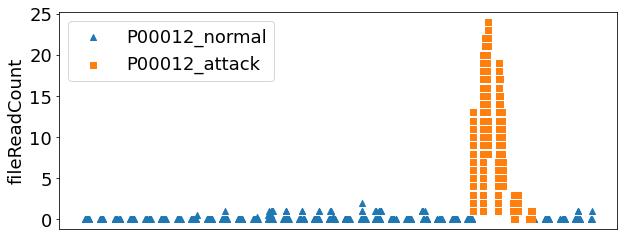

In [34]:
GenReadWindowDf = pd.DataFrame(columns=['windowTime', 'fileReadCount', 'tag'])
idx = 0
for key, vals in GenUserEmailReadPortionWindowInfo.items():
    if key == 'P00012':
        for val in vals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00012_normal']
            idx += 1


for key, Avals in GenUserAttackEmailReadPortionWindowInfo['A'].items():
    if key == 'P00012':
        for val in Avals:
            GenReadWindowDf.loc[idx] = [val['windowTime'], val['fileReadCount'], 'P00012_attack']
            idx += 1
            
print(GenReadWindowDf[GenReadWindowDf['tag']=='P00012_attack'])
markers = ['^', 's']
tags = ['P00012_normal', 'P00012_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenReadWindowDf[GenReadWindowDf['tag']==tags[i]]['fileReadCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileReadCount')
plt.show()

In [35]:
def genActionsCopyParse(actions, windowTime, fileLoc):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)

        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break

        fileCopyCount = 0
        windowFlag = False
        if action['act'] == 'fileCreate':
            revCWindow = list(reversed(cWindow))
            
            for cAcction in revCWindow:
                if cAcction['act'] == 'fileRead' and cAcction['fileLoc'] == str(fileLoc) and cAcction['fileName'] in action['fileName']:
                    windowFlag = True
                    fileCopyCount += 1
                    break
                    
        if windowFlag:
            for idx, restAction in enumerate(revCWindow):
                if restAction['act'] == 'fileCreate':
                    for restCAction in revCWindow[idx+1:]:
                        if restCAction['act'] == 'fileRead' and restCAction['fileLoc'] == str(fileLoc) and restCAction['fileName'] in restAction['fileName']:
                            fileCopyCount += 1
                            break
            
            cWindowInfo = {}
            cWindowInfo['windowTimeStr'] = str(currentTime)
            cWindowInfo['windowTime'] = currentTime
            cWindowInfo['fileCopyCount'] = fileCopyCount
            userActionInfo.append(cWindowInfo)

        cWindow.append(action)

        preWindow = cWindow
        
    return userActionInfo

GenUserCopyWindowInfo = {}
for user in GenUserActs:
    GenUserCopyWindowInfo[user] = genActionsCopyParse(GenUserActs[user], windowTime, 2)
    
GenUserAttackCopyWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackCopyWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackCopyWindowInfo[attack][user] = genActionsCopyParse(GenUserAttackActs[attack][user], windowTime, 2)
        
print(GenUserCopyWindowInfo['P00012'])

[{'windowTimeStr': '2024-09-08 17:56:00.274725', 'windowTime': datetime.datetime(2024, 9, 8, 17, 56, 0, 274725), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-10 14:11:43.650310', 'windowTime': datetime.datetime(2024, 9, 10, 14, 11, 43, 650310), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-12 15:48:13.798050', 'windowTime': datetime.datetime(2024, 9, 12, 15, 48, 13, 798050), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-13 09:39:04.634518', 'windowTime': datetime.datetime(2024, 9, 13, 9, 39, 4, 634518), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-13 12:21:51.215538', 'windowTime': datetime.datetime(2024, 9, 13, 12, 21, 51, 215538), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-13 13:44:09.996657', 'windowTime': datetime.datetime(2024, 9, 13, 13, 44, 9, 996657), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-13 15:03:15.500108', 'windowTime': datetime.datetime(2024, 9, 13, 15, 3, 15, 500108), 'fileCopyCount': 1}, {'windowTimeStr': '2024-09-13 17:06:48.193775', 'windowTime'

                   windowTime fileCopyCount            tag
0  2024-09-08 17:56:00.274725             1  P00012_normal
1  2024-09-10 14:11:43.650310             1  P00012_normal
2  2024-09-12 15:48:13.798050             1  P00012_normal
3  2024-09-13 09:39:04.634518             1  P00012_normal
4  2024-09-13 12:21:51.215538             1  P00012_normal
5  2024-09-13 13:44:09.996657             1  P00012_normal
6  2024-09-13 15:03:15.500108             1  P00012_normal
7  2024-09-13 17:06:48.193775             1  P00012_normal
8  2024-09-14 12:55:16.072105             1  P00012_normal
9  2024-09-15 14:03:59.587344             1  P00012_normal
10 2024-09-16 16:48:09.894798             1  P00012_normal
11 2024-09-17 10:19:04.673866             1  P00012_normal
12 2024-09-17 14:37:25.813780             1  P00012_normal
13 2024-09-19 12:11:46.487948             1  P00012_normal
14 2024-09-19 12:29:26.861086             2  P00012_normal
15 2024-09-20 09:18:53.884648             1  P00012_norm

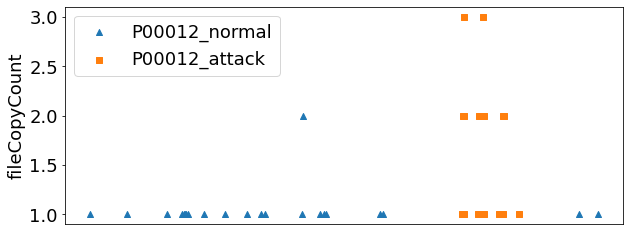

In [38]:
GenCopyWindowDf = pd.DataFrame(columns=['windowTime', 'fileCopyCount', 'tag'])
idx = 0
for key, vals in GenUserCopyWindowInfo.items():
    if key == 'P00012':
        for val in vals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00012_normal']
            idx += 1


for key, Avals in GenUserAttackCopyWindowInfo['A'].items():
    if key == 'P00012':
        for val in Avals:
            GenCopyWindowDf.loc[idx] = [val['windowTime'], val['fileCopyCount'], 'P00012_attack']
            idx += 1
            
print(GenCopyWindowDf[GenCopyWindowDf['tag']=='P00012_normal'])
markers = ['^', 's']
tags = ['P00012_normal', 'P00012_attack']

plt.figure(figsize=(15*2/3, 6*2/3))
plt.rc('font', size=18)
plt.rc('xtick', labelsize=10) 
plt.gca().axes.xaxis.set_visible(False)

for i, marker in enumerate(markers):
    x_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['windowTime']
    y_axis = GenCopyWindowDf[GenCopyWindowDf['tag']==tags[i]]['fileCopyCount']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('windowTime')
plt.ylabel('fileCopyCount')
plt.show()